In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%cd drive/MyDrive

/content/drive/MyDrive


In [4]:
# Factors
# Small Cap vs Big Cap
# High Volume vs. Small Volume
# Price above average, price below average
# High Volatility, low volatility

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
coin_list = ['Aave',
                 'Bitcoin',
                 'BinanceCoin',
                 'Ethereum',
                 'Cardano',
                 'Cosmos',
                 'ChainLink',
                 'CryptocomCoin',
                 'Dogecoin',
                 'EOS',
                 'Ethereum',
                 'Iota',
                 'Litecoin',
                 'Monero',
                 'NEM',
                 'Polkadot',
                 'Tether',
                 'Solana',
                 'Stellar',
                 'Tether',
                 'Tron',
                 'Uniswap',
                 'WrappedBitcoin',
                 'XRP']

df_list = []
for coin in coin_list:
  df = pd.read_csv('archive/coin_{}.csv'.format(coin))
  df_list.append(df)

data = df_list[0]
df_list = df_list[1:]

for df in df_list:
  data = data.append(df)

# Ensure all the symbols are there
data.Symbol.unique()

array(['AAVE', 'BTC', 'BNB', 'ETH', 'ADA', 'ATOM', 'LINK', 'CRO', 'DOGE',
       'EOS', 'MIOTA', 'LTC', 'XMR', 'XEM', 'DOT', 'USDT', 'SOL', 'XLM',
       'TRX', 'UNI', 'WBTC', 'XRP'], dtype=object)

In [7]:
# Sort by date, Symbol
data = data.sort_values(['Date', 'Symbol'],
              ascending = [True, True])

# Calculate percentage return by symbol
sym_list = list(data.Symbol.unique())

data_with_return = data
i=0

return_dfs = []

# Iterate through every coin, create a new df with Symbol, Date, Percentage Return
for sym in sym_list:
  print(sym)
  d_pct_return = data.loc[data['Symbol'] == sym]
  d_pct_return = d_pct_return.drop_duplicates(subset=['Date'])

  pct_return_series = d_pct_return.Close.pct_change()
  date_series = d_pct_return.Date
  sym_series = pd.Series([sym]*len(date_series))

  Data = {
      'Date': date_series,
      'Symbol': sym_series,
      'PctReturn': pct_return_series
  }

  d = pd.DataFrame(Data)

  return_dfs.append(d)

data_return = return_dfs[0]
return_dfs = return_dfs[1:]

for df in return_dfs:
  data_return = data_return.append(df)

data = data.merge(data_return, on=['Date', 'Symbol'], how='left')


BTC
LTC
XRP
DOGE
XMR
XLM
USDT
XEM
ETH
MIOTA
EOS
BNB
TRX
LINK
ADA
CRO
WBTC
ATOM
SOL
DOT
UNI
AAVE


In [8]:
# New factor - price variation over day
# Calculated as (High - Low)/Low
# Using as proxy for volatility

data['DailyVariation'] = (data['High']-data['Low'])/data['Low']
data.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,PctReturn,DailyVariation
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.44400,144.539993,0.0,1.603769e+09,NaN,0.100657
1,1,Litecoin,LTC,2013-04-29 23:59:59,4.573600,4.225640,4.36676,4.383900,0.0,7.538896e+07,NaN,0.082345
2,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.00000,139.000000,0.0,1.542813e+09,-0.038328,0.096083
3,2,Litecoin,LTC,2013-04-30 23:59:59,4.572380,4.168960,4.40352,4.296490,0.0,7.402092e+07,-0.019939,0.096768
4,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.00000,116.989998,0.0,1.298955e+09,-0.158345,0.298645


In [33]:
# Small Cap vs Big Cap
# High Volume vs. Small Volume
# Price above average, price below average
# High Volatility, low volatility


factors_list = {
    'big_vs_small': {
        'var_name': 'Marketcap',
        'need_compute': True
    },
    'vol_high_vs_low': {
        'var_name': 'Volume',
        'need_compute': True
    },
    'price_high_vs_low': {
        'var_name': 'Close',
        'need_compute': True
    },
    'daily_variation': {
        'var_name': 'DailyVariation',
        'need_compute': True
    },
    'crypto_mkt': {
        'need_compute': False
    }
}

data['Date'] = pd.to_datetime(data['Date'])  

start_date = '2018-01-01'
end_date = '2020-12-31'
for factor, det in factors_list.items():
  if not det['need_compute']:
    continue

  print(factor)
  # Get data between 2020 and 2021
  mask = (data['Date'] > start_date) & (data['Date'] <= end_date)

  data_recent = data.loc[mask]
  
  # Get average FACTOR by symbol
  average_by_factor = data_recent.groupby('Symbol')[det['var_name']].mean().sort_values()
  average_by_factor = average_by_factor.reset_index()

  # Get top 10, bottom 10 symbols sorted by factor
  half_index = (len(average_by_factor)//2)
  bottom_factor = list((average_by_factor.iloc[:half_index,:]).Symbol)
  top_factor = list((average_by_factor.iloc[half_index:,:]).Symbol)

  # Get average return by FACTOR, date
  data_recent['TopOrBottom'] = np.where(data_recent['Symbol'].isin(bottom_factor), 'Bottom', 'Top')

  return_factor_portfolios = data_recent.groupby(['Date', 'TopOrBottom'])['PctReturn'].mean().reset_index()
  return_factor_portfolios = return_factor_portfolios.pivot(index='Date', columns='TopOrBottom', values='PctReturn')
  return_factor_portfolios['{}_return'.format(factor)] = return_factor_portfolios['Top'] - return_factor_portfolios['Bottom']

  
  # Save to dictionary
  factors_list[factor]['return'] = return_factor_portfolios.reset_index()[['Date', '{}_return'.format(factor)]]


big_vs_small
vol_high_vs_low
price_high_vs_low
daily_variation


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [51]:
# Add crypto market factor

data_merged = data_recent
def my_agg(x):
    names = {'crypto_mkt_return': (x['Marketcap'] * x['PctReturn']).sum()/x['Marketcap'].sum()}
    return pd.Series(names, index=['crypto_mkt_return'])

data_merged = data_merged.merge(data_merged.groupby("Date").apply(my_agg).reset_index(), on='Date', how='left')

In [35]:
factors_list['big_vs_small']

{'var_name': 'Marketcap',
 'need_compute': True,
 'return': TopOrBottom                Date  big_vs_small_return
 0           2018-01-01 23:59:59            -0.031431
 1           2018-01-02 23:59:59             0.091335
 2           2018-01-03 23:59:59             0.010929
 3           2018-01-04 23:59:59             0.023479
 4           2018-01-05 23:59:59             0.043419
 ...                         ...                  ...
 1090        2020-12-26 23:59:59             0.013107
 1091        2020-12-27 23:59:59            -0.001727
 1092        2020-12-28 23:59:59            -0.004644
 1093        2020-12-29 23:59:59             0.013240
 1094        2020-12-30 23:59:59            -0.003404
 
 [1095 rows x 2 columns]}

In [52]:
from sklearn.linear_model import LinearRegression

# Add factor returns to price data
for factor, det in factors_list.items():
  if det['need_compute']:
    data_merged = data_merged.merge(det['return'], on='Date', how='left')

model_data = {}

for sym in sym_list:
  # Get t-1 factors
  data_temp = data_merged.loc[data_merged['Symbol'] == sym]
  data_temp = data_temp.drop_duplicates()

  if len(data_temp)<=0:
    continue

  print('{} {}'.format(sym, len(data_temp)))

  for factor in factors_list.keys():
    data_temp['{}_return_previous'.format(factor)] = data_temp['{}_return'.format(factor)].shift(1)

  data_temp = data_temp.sort_values('Date')
  data_temp['PriceMA'] = data_temp['PctReturn'].rolling(window=30, closed= "left").mean()

  # data_temp.dropna()
  data_temp = data_temp.dropna()

  # Fit regression where you use last 30 days prices to predict next day
  X_last30 = data_temp['PriceMA'].to_numpy().reshape(-1, 1)
  Y = data_temp['PctReturn'].to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X_last30, Y, test_size=0.4, random_state=42)

  reg = LinearRegression().fit(X_train, y_train)
  model_sym_data = {}
  model_sym_data['intercept'] = reg.intercept_
  model_sym_data['coef'] = reg.coef_
  model_sym_data['r2_train'] = reg.score(X_train, y_train)
  model_sym_data['r2_validation'] = reg.score(X_test, y_test)

  model_data[sym] = {}
  model_data[sym]['last30'] = model_sym_data

  # Fit regression where you use t-1 factors
  X_factor = data_temp[['{}_return'.format(x) for x in factors_list.keys()]].to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X_factor, Y, test_size=0.4, random_state=42)

  reg = LinearRegression().fit(X_train, y_train)
  model_sym_data = {}
  model_sym_data['intercept'] = reg.intercept_
  model_sym_data['coef'] = reg.coef_
  model_sym_data['r2_train'] = reg.score(X_train, y_train)
  model_sym_data['r2_validation'] = reg.score(X_test, y_test)

  model_data[sym]['factor'] = model_sym_data
  
  # HOPEFULLY the performance of factor model is better

BTC 1095
LTC 1095
XRP 1095
DOGE 1095
XMR 1095
XLM 1095
USDT 1095
XEM 1095
ETH 1095
MIOTA 1095
EOS 1095
BNB 1095
TRX 1095
LINK 1095
ADA 1095
CRO 747
WBTC 700
ATOM 657
SOL 264
DOT 132
UNI 104
AAVE 87


Text(0, 0.5, 'Daily Return (%)')

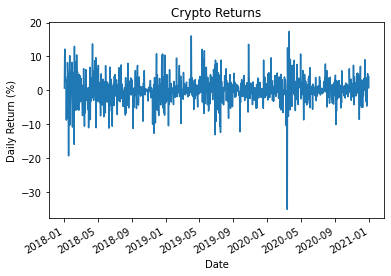

In [47]:
(data_merged.reset_index().set_index('Date')['crypto_mkt_return']*100).plot.line()
plt.title('Crypto Returns')
plt.ylabel('Daily Return (%)')

In [48]:
data_temp

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,big_vs_small_return,vol_high_vs_low_return,price_high_vs_low_return,daily_variation_return,big_vs_small_return_previous,vol_high_vs_low_return_previous,price_high_vs_low_return_previous,daily_variation_return_previous,crypto_mkt_return_previous,PriceMA
19962,32,Aave,AAVE,2020-11-05 23:59:59,32.303040,25.966155,27.715080,30.955627,8.521241e+07,3.502055e+08,...,-0.020441,0.004363,0.032491,0.005889,0.030528,0.011913,0.004030,-0.021119,0.015739,-0.018536
19986,33,Aave,AAVE,2020-11-06 23:59:59,40.769075,30.855128,30.955118,38.457441,1.473047e+08,4.358764e+08,...,-0.063694,-0.049352,-0.014349,0.096750,-0.020441,0.004363,0.032491,0.005889,0.074306,-0.007863
20010,34,Aave,AAVE,2020-11-07 23:59:59,51.427992,38.457441,38.457441,44.604900,2.005801e+08,5.077072e+08,...,-0.021042,-0.012299,0.000339,0.013977,-0.063694,-0.049352,-0.014349,0.096750,0.027626,0.002037
20034,35,Aave,AAVE,2020-11-08 23:59:59,54.786360,42.864255,44.604900,53.749379,1.747060e+08,6.130149e+08,...,-0.048517,-0.021794,0.028786,0.042117,-0.021042,-0.012299,0.000339,0.013977,-0.041999,0.004304
20058,36,Aave,AAVE,2020-11-09 23:59:59,58.364111,49.860129,53.749374,54.886500,3.860113e+08,6.268433e+08,...,0.008070,-0.000102,0.013482,-0.003976,-0.048517,-0.021794,0.028786,0.042117,0.039314,0.008813
20082,37,Aave,AAVE,2020-11-10 23:59:59,70.309825,53.179036,54.886505,67.001111,4.337932e+08,7.807003e+08,...,-0.047841,-0.022452,0.007576,0.047410,0.008070,-0.000102,0.013482,-0.003976,-0.011849,0.007869
20106,38,Aave,AAVE,2020-11-11 23:59:59,68.778598,53.716754,67.001111,54.699647,3.541368e+08,6.380255e+08,...,0.040336,0.033655,-0.001238,-0.040323,-0.047841,-0.022452,0.007576,0.047410,0.002586,0.014869
20130,39,Aave,AAVE,2020-11-12 23:59:59,59.618315,50.523102,54.699623,51.632418,2.445056e+08,6.034218e+08,...,0.008635,0.008952,0.007145,-0.018202,0.040336,0.033655,-0.001238,-0.040323,0.022883,0.007018
20154,40,Aave,AAVE,2020-11-13 23:59:59,66.123660,51.179153,51.632434,63.399072,3.188521e+08,7.433967e+08,...,-0.042362,0.011859,0.050418,0.048164,0.008635,0.008952,0.007145,-0.018202,0.020997,0.005860
20178,41,Aave,AAVE,2020-11-14 23:59:59,68.377043,57.897273,63.399072,67.016113,2.436989e+08,7.868141e+08,...,-0.004719,-0.006903,0.001449,-0.001657,-0.042362,0.011859,0.050418,0.048164,0.012154,0.013331


In [53]:
results_df_dict = {
    'Symbol': [],
    'Last30Model_r2_training': [],
    'Last30Model_r2_val': [],
    'Factor_r2_training': [],
    'Factor_r2_val': []
}

for k, v in model_data.items():
  results_df_dict['Symbol'].append(k)
  results_df_dict['Last30Model_r2_training'].append(v['last30']['r2_train'])
  results_df_dict['Last30Model_r2_val'].append(v['last30']['r2_validation'])
  results_df_dict['Factor_r2_training'].append(v['factor']['r2_train'])
  results_df_dict['Factor_r2_val'].append(v['factor']['r2_validation'])

results_df_dict = pd.DataFrame(results_df_dict)
results_df_dict

,Symbol,Last30Model_r2_training,Last30Model_r2_val,Factor_r2_training,Factor_r2_val
0,BTC,2.659747e-03,-0.015067,0.948142,0.935190
1,LTC,6.251851e-04,-0.008470,0.752522,0.755263
2,XRP,6.552126e-04,-0.010265,0.701696,0.671327
3,DOGE,4.180839e-03,-0.018819,0.639435,0.577125
4,XMR,3.501284e-03,-0.013761,0.770830,0.707919
5,XLM,1.404489e-03,-0.020533,0.698458,0.622162
6,USDT,9.576893e-02,0.075635,0.029652,-0.065375
7,XEM,1.251719e-04,0.000165,0.620406,0.539067
8,ETH,5.840159e-07,-0.010593,0.895010,0.879006
9,MIOTA,3.419904e-04,-0.044600,0.728783,0.650538


In [49]:
model_data

{'BTC': {'last30': {'intercept': 8370.58322282623,
   'coef': array([214902.07029644]),
   'r2_train': 0.17686015917223274,
   'r2_validation': 0.1792404587226588},
  'factor': {'intercept': 8710.129414430314,
   'coef': array([  2080.74866674, -17913.44061772,  14516.43970537,  -3991.2891991 ,
            3739.94693732]),
   'r2_train': 0.019022661416774445,
   'r2_validation': -0.03470918717303073}},
 'LTC': {'last30': {'intercept': 72.75696005815504,
   'coef': array([680.64725624]),
   'r2_train': 0.02738196371928381,
   'r2_validation': 0.03407650718290878},
  'factor': {'intercept': 73.42651158054484,
   'coef': array([-61.43243533,  31.67312171, 151.22262   ,  36.68245972,
          -68.06944477]),
   'r2_train': 0.003582653318710216,
   'r2_validation': -0.004735267207233385}},
 'XRP': {'last30': {'intercept': 0.3684107922688594,
   'coef': array([1.53271048]),
   'r2_train': 0.0068070648158128355,
   'r2_validation': 0.010859331420941754},
  'factor': {'intercept': 0.368508579

In [22]:
# Generate ACF Plots

import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(OverallData.dropna()['BTCDailyReturn'], title='BTC Auto-Correlation')
sm.graphics.tsa.plot_acf(OverallData.dropna()['ETHDailyReturn'], title='ETH Auto-Correlation')

# Look at cross-correlation of lagged factors and eth, btc return
btc_mktrf_ccf = sm.tsa.stattools.ccf(OverallData.dropna()['BTCDailyReturn'], OverallData.dropna()['Mkt-RF'], adjusted=False)
plt.plot(len(btc_mktrf_ccf[0:50]), btc_mktrf_ccf[0:50])


NameError: ignored

In [41]:
data

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
0,1,Litecoin,LTC,2013-04-29 23:59:59,4.573600,4.225640,4.366760,4.383900,0.000000e+00,7.538896e+07
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
1,2,Litecoin,LTC,2013-04-30 23:59:59,4.572380,4.168960,4.403520,4.296490,0.000000e+00,7.402092e+07
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
...,...,...,...,...,...,...,...,...,...,...
887,888,Wrapped Bitcoin,WBTC,2021-07-06 23:59:59,35004.772491,33700.560335,33772.552729,34189.372826,2.035448e+08,6.713947e+09
2287,2288,NEM,XEM,2021-07-06 23:59:59,0.136318,0.128804,0.130591,0.133591,6.635341e+07,1.202315e+09
2526,2527,Stellar,XLM,2021-07-06 23:59:59,0.267757,0.253547,0.253931,0.260190,3.604261e+08,6.049985e+09
2601,2602,Monero,XMR,2021-07-06 23:59:59,222.137136,212.296827,214.470724,222.137136,1.678620e+08,3.986738e+09
